In [8]:
!uv add pyplot
!uv add scipy
!uv add scikit-learn
!uv add pandas
!uv add json
!uv add numpy
!uv add openai
!uv add tqdm
!uv add matplotlib

zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv
zsh:1: command not found: uv


In [9]:
import pandas as pd
import json
import numpy as np
from openai import OpenAI
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# 1. 데이터 로드 및 전처리
print("데이터셋 로딩 중...")
ds = load_dataset("birdsql/bird_sql_dev_20251106")
df = ds['dev_20251106'].to_pandas()
hard_df = df[df['difficulty'] == 'challenging'].copy()
print(f"로드 완료. 'challenging' 난이도 데이터 {len(hard_df)}개.")

# 2. 훈련/테스트 데이터 분리
print("데이터를 훈련셋과 테스트셋으로 분리 중...")
train_df, test_df = train_test_split(hard_df, test_size=0.2, random_state=42)
print(f"훈련셋: {len(train_df)}개, 테스트셋: {len(test_df)}개")

# 3. OpenAI 클라이언트 설정
print("OpenAI 클라이언트 설정 중...")
MODEL_NAME="Qwen/Qwen3-Next-80B-A3B-Instruct"
MODEL_BASE_URI="http://211.47.56.81:7972/v1"
MODEL_API_KEY="token-abc123"
client = OpenAI(api_key=MODEL_API_KEY, base_url=MODEL_BASE_URI)
print("설정 완료.")


데이터셋 로딩 중...
로드 완료. 'challenging' 난이도 데이터 231개.
데이터를 훈련셋과 테스트셋으로 분리 중...
훈련셋: 184개, 테스트셋: 47개
OpenAI 클라이언트 설정 중...
설정 완료.


In [10]:
client.chat.completions.create(
    model=MODEL_NAME,
    messages=[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "What is the capital of the moon?"}]
)


ChatCompletion(id='chatcmpl-70e898eb077840c39b12b8a5fb029823', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The Moon does not have a capital, because it is not a country or a sovereign political entity. It is Earth’s only natural satellite and has no government, population, or cities. While there have been lunar missions by various nations and plans for future bases (like NASA’s Artemis program or China’s lunar research station), no human settlement or capital exists on the Moon as of now.\n\nSo, in short: **The Moon has no capital.**', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1764497958, model='Qwen/Qwen3-Next-80B-A3B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=92, prompt_tokens=27, total_tokens=119, completion_tokens_details=None,

In [11]:
# 4. Q-learning 기반 프롬프트 최적화를 위한 정의

# --- 스키마 정보 (유지) ---
schema_info = """
Schema for frpm:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'Academic Year', 'TEXT', 0, None, 0)
(2, 'County Code', 'TEXT', 0, None, 0)
(3, 'District Code', 'INTEGER', 0, None, 0)
(4, 'School Code', 'TEXT', 0, None, 0)
(5, 'County Name', 'TEXT', 0, None, 0)
(6, 'District Name', 'TEXT', 0, None, 0)
(7, 'School Name', 'TEXT', 0, None, 0)
(8, 'District Type', 'TEXT', 0, None, 0)
(9, 'School Type', 'TEXT', 0, None, 0)
(10, 'Educational Option Type', 'TEXT', 0, None, 0)
(11, 'NSLP Provision Status', 'TEXT', 0, None, 0)
(12, 'Charter School (Y/N)', 'INTEGER', 0, None, 0)
(13, 'Charter School Number', 'TEXT', 0, None, 0)
(14, 'Charter Funding Type', 'TEXT', 0, None, 0)
(15, 'IRC', 'INTEGER', 0, None, 0)
(16, 'Low Grade', 'TEXT', 0, None, 0)
(17, 'High Grade', 'TEXT', 0, None, 0)
(18, 'Enrollment (K-12)', 'REAL', 0, None, 0)
(19, 'Free Meal Count (K-12)', 'REAL', 0, None, 0)
(20, 'Percent (%) Eligible Free (K-12)', 'REAL', 0, None, 0)
(21, 'FRPM Count (K-12)', 'REAL', 0, None, 0)
(22, 'Percent (%) Eligible FRPM (K-12)', 'REAL', 0, None, 0)
(23, 'Enrollment (Ages 5-17)', 'REAL', 0, None, 0)
(24, 'Free Meal Count (Ages 5-17)', 'REAL', 0, None, 0)
(25, 'Percent (%) Eligible Free (Ages 5-17)', 'REAL', 0, None, 0)
(26, 'FRPM Count (Ages 5-17)', 'REAL', 0, None, 0)
(27, 'Percent (%) Eligible FRPM (Ages 5-17)', 'REAL', 0, None, 0)
(28, '2013-14 CALPADS Fall 1 Certification Status', 'INTEGER', 0, None, 0)

Schema for satscores:
(0, 'cds', 'TEXT', 1, None, 1)
(1, 'rtype', 'TEXT', 1, None, 0)
(2, 'sname', 'TEXT', 0, None, 0)
(3, 'dname', 'TEXT', 0, None, 0)
(4, 'cname', 'TEXT', 0, None, 0)
(5, 'enroll12', 'INTEGER', 1, None, 0)
(6, 'NumTstTakr', 'INTEGER', 1, None, 0)
(7, 'AvgScrRead', 'INTEGER', 0, None, 0)
(8, 'AvgScrMath', 'INTEGER', 0, None, 0)
(9, 'AvgScrWrite', 'INTEGER', 0, None, 0)
(10, 'NumGE1500', 'INTEGER', 0, None, 0)

Schema for schools:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'NCESDist', 'TEXT', 0, None, 0)
(2, 'NCESSchool', 'TEXT', 0, None, 0)
(3, 'StatusType', 'TEXT', 1, None, 0)
(4, 'County', 'TEXT', 1, None, 0)
(5, 'District', 'TEXT', 1, None, 0)
(6, 'School', 'TEXT', 0, None, 0)
(7, 'Street', 'TEXT', 0, None, 0)
(8, 'StreetAbr', 'TEXT', 0, None, 0)
(9, 'City', 'TEXT', 0, None, 0)
(10, 'Zip', 'TEXT', 0, None, 0)
(11, 'State', 'TEXT', 0, None, 0)
(12, 'MailStreet', 'TEXT', 0, None, 0)
(13, 'MailStrAbr', 'TEXT', 0, None, 0)
(14, 'MailCity', 'TEXT', 0, None, 0)
(15, 'MailZip', 'TEXT', 0, None, 0)
(16, 'MailState', 'TEXT', 0, None, 0)
(17, 'Phone', 'TEXT', 0, None, 0)
(18, 'Ext', 'TEXT', 0, None, 0)
(19, 'Website', 'TEXT', 0, None, 0)
(20, 'OpenDate', 'DATE', 0, None, 0)
(21, 'ClosedDate', 'DATE', 0, None, 0)
(22, 'Charter', 'INTEGER', 0, None, 0)
(23, 'CharterNum', 'TEXT', 0, None, 0)
(24, 'FundingType', 'TEXT', 0, None, 0)
(25, 'DOC', 'TEXT', 1, None, 0)
(26, 'DOCType', 'TEXT', 1, None, 0)
(27, 'SOC', 'TEXT', 0, None, 0)
(28, 'SOCType', 'TEXT', 0, None, 0)
(29, 'EdOpsCode', 'TEXT', 0, None, 0)
(30, 'EdOpsName', 'TEXT', 0, None, 0)
(31, 'EILCode', 'TEXT', 0, None, 0)
(32, 'EILName', 'TEXT', 0, None, 0)
(33, 'GSoffered', 'TEXT', 0, None, 0)
(34, 'GSserved', 'TEXT', 0, None, 0)
(35, 'Virtual', 'TEXT', 0, None, 0)
(36, 'Magnet', 'INTEGER', 0, None, 0)
(37, 'Latitude', 'REAL', 0, None, 0)
(38, 'Longitude', 'REAL', 0, None, 0)
(39, 'AdmFName1', 'TEXT', 0, None, 0)
(40, 'AdmLName1', 'TEXT', 0, None, 0)
(41, 'AdmEmail1', 'TEXT', 0, None, 0)
(42, 'AdmFName2', 'TEXT', 0, None, 0)
(43, 'AdmLName2', 'TEXT', 0, None, 0)
(44, 'AdmEmail2', 'TEXT', 0, None, 0)
(45, 'AdmFName3', 'TEXT', 0, None, 0)
(46, 'AdmLName3', 'TEXT', 0, None, 0)
(47, 'AdmEmail3', 'TEXT', 0, None, 0)
(48, 'LastUpdate', 'DATE', 1, None, 0)
"""


# --- 초기 시스템 프롬프트 ---
SystemPrompt = f"""당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.
{schema_info}를 참조해서 사용자의 질문을 데이터베이스 쿼리로 변환하는 것이 목표입니다.
"""


# --- 초기 시스템 프롬프트 ---
SystemPrompt = f"""당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.
"""

# --- Reflexion(자기 성찰) 생성을 위한 프롬프트 ---
reflexion_prompt_template = """당신은 당신이 작성한 SQL 쿼리의 오류를 분석하고 수정하는 역할을 맡았습니다.

방금 당신이 작성한 쿼리는 실행 결과가 정답과 일치하지 않았습니다.

**상황 정보:**

1. **User Query:** {query}
2. **Generated SQL:** {previous_sql}
3. **Evaluator Feedback:** {feedback}

**지시:**
평가자의 피드백을 참고하여, 이전 SQL이 왜 틀렸는지 간결하게 원인을 분석하세요.
그리고 다음 시도에서 **어떻게 수정해야 정답을 맞출 수 있을지** 구체적인 수정 계획(Plan)을 한 문장으로 작성하세요.

**출력 형식:**
오직 수정 계획(Reflection)만 텍스트로 출력하세요.
"""

# --- 평가 및 보상 점수 생성을 위한 프롬프트 ---
evaluation_prompt_template = """당신은 SQL 쿼리 평가 전문가입니다. 당신의 임무는 생성된 SQL 쿼리의 실행 결과가 정답(Evidence)과 일치하는지 평가하고, 정량적인 보상 점수와 상세한 피드백을 제공하는 것입니다.

**평가 기준:**
- **+3점 (완벽히 정답):** 실행 결과가 정답(Evidence)과  SQL(정답) 모든 면에서(데이터, 순서, 형식) 완벽하게 일치합니다.
- **+1점 (정답):** 실행 결과가 정답(Evidence)과 모든 면에서 일치하지만, SQL(정답)과 출력 순서가 다르거나 사소한 형식 차이가 있습니다.
- **+0.7점 (의미상 정답):** 데이터는 정확하지만, Evidence와 출력 순서가 다르거나 사소한 형식 차이가 있습니다.
- **-0.5점 (실행은 되나 오답):** SQL 쿼리가 문법적으로는 맞아 실행되지만, 질문의 의도를 잘못 파악하여 틀린 결과를 반환합니다.
- **-1.0점 (실행 불가 또는 심각한 오류):** SQL 문법 오류가 있어 실행되지 않거나, 질문의 핵심 요구사항을 완전히 놓쳤습니다.

**평가 대상 정보:**
1. **User Query (사용자 질문):** {query}
2. **Evidence (정답 데이터):** {evidence}
3. **SQL (정답):** {sql}
4. **LLM Result (생성된 SQL 쿼리):** {llm_result}

**출력 형식:**
평가 결과를 다음 형식에 맞춰 **오직 JSON 객체 하나만** 출력해주세요. 당신의 의견이나 다른 설명은 절대 포함하지 마세요.
```json
{{
  "reward_score": "평가 기준에 따른 -1.0에서 +1.0 사이의 숫자 점수",
  "correctness": "'Correct', 'Partially Correct', 'Incorrect' 중 하나",
  "feedback": "점수를 매긴 이유와, 쿼리를 개선하기 위한 구체적이고 건설적인 피드백을 작성해주세요."
}}
```
"""

batch_prompt_updater_template = """당신은 LLM의 성능을 극대화하는 프롬프트 엔지니어링 전문가입니다.
당신의 임무는 이전 버전의 시스템 프롬프트와, 한 배치(batch)에서 발생한 여러 실패 사례를 종합적으로 분석하여, **더욱 완성도 높은 새 버전의 시스템 프롬프트를 재작성**하는 것입니다.

**이전 버전 시스템 프롬프트:**
---
{current_prompt}
---

**이번 배치에서 발생한 실패 사례 요약:**
---
{batch_failures_summary}
---

**과거 누적 실패 기록 (참고용):**
---
{failure_history}
---

**참고: 아래는 실패를 평가할 때 사용된 기준입니다.**
---
{evaluation_criteria}
---
**지침:**
이번 배치의 실패 원인을 분석하여 개선된 시스템 프롬프트를 작성하세요. 이전 프롬프트의 장점은 유지하되, 반복되는 실수를 방지할 수 있도록 명확한 원칙을 제시하세요.

**출력 형식:**
개선된 시스템 프롬프트만 출력하세요.
"""

print("강화학습용 프롬프트 템플릿 정의 완료.")

# ============================================
# Q-learning 기반 프롬프트 최적화 시스템
# ============================================

from typing import Dict, Tuple, List
from collections import defaultdict
import random

# --- 프롬프트 상태 정의 ---
class PromptState:
    """프롬프트의 구조적 상태를 나타내는 클래스"""
    def __init__(self):
        self.has_schema = False  # 스키마 설명 포함 여부
        self.few_shot_count = 0  # Few-shot 예시 개수 (0, 1, 2, 3)
        self.has_reasoning = False  # Reasoning 문구 포함 여부
        self.formality_level = 0  # 형식성 레벨 (0: 일반, 1: 엄격, 2: 매우 엄격)
        self.has_examples = False  # 예시 포함 여부
        self.recent_success_rate = 0.0  # 최근 성공률 (0.0 ~ 1.0)
        self.recent_avg_reward = 0.0  # 최근 평균 보상 (-1.0 ~ 3.0)
    
    def to_tuple(self) -> Tuple:
        """상태를 튜플로 변환 (딕셔너리 키로 사용)"""
        return (
            self.has_schema,
            min(self.few_shot_count, 3),  # 최대 3으로 제한
            self.has_reasoning,
            min(self.formality_level, 2),  # 최대 2로 제한
            self.has_examples,
            round(self.recent_success_rate, 1),  # 소수점 1자리로 반올림
            round(self.recent_avg_reward, 1)  # 소수점 1자리로 반올림
        )
    
    def __hash__(self):
        return hash(self.to_tuple())
    
    def __eq__(self, other):
        return isinstance(other, PromptState) and self.to_tuple() == other.to_tuple()

# --- 액션 정의 ---
ACTIONS = {
    'add_schema': '스키마 설명 추가',
    'remove_schema': '스키마 설명 제거',
    'add_few_shot': 'Few-shot 예시 1개 추가',
    'remove_few_shot': 'Few-shot 예시 1개 제거',
    'add_reasoning': 'Reasoning 문구 추가',
    'remove_reasoning': 'Reasoning 문구 제거',
    'increase_formality': '형식성 증가',
    'decrease_formality': '형식성 감소',
    'add_examples': '예시 추가',
    'remove_examples': '예시 제거',
    'no_change': '변경 없음'
}

# --- 프롬프트 생성 함수 ---
def build_prompt_from_state(state: PromptState, base_prompt: str) -> str:
    """상태에 따라 프롬프트를 구성"""
    prompt_parts = [base_prompt]
    
    if state.has_schema:
        prompt_parts.append(f"\n\n다음은 데이터베이스 스키마 정보입니다:\n{schema_info}")
    
    if state.has_reasoning:
        prompt_parts.append("\n\n**중요:** SQL을 생성하기 전에 다음을 고려하세요:\n"
                          "1. 사용자 질문의 의도를 정확히 파악하세요.\n"
                          "2. 필요한 테이블과 컬럼을 식별하세요.\n"
                          "3. JOIN 조건과 WHERE 조건을 신중하게 작성하세요.\n"
                          "4. SQLite 문법에 맞게 작성하세요.")
    
    if state.formality_level == 1:
        prompt_parts.append("\n\n**엄격한 규칙:**\n"
                          "- 정확한 테이블명과 컬럼명을 사용하세요.\n"
                          "- SQL 문법 오류를 절대 허용하지 마세요.")
    elif state.formality_level == 2:
        prompt_parts.append("\n\n**매우 엄격한 규칙:**\n"
                          "- 모든 테이블명과 컬럼명은 대소문자를 정확히 일치시켜야 합니다.\n"
                          "- SQL 문법 오류는 절대 허용되지 않습니다.\n"
                          "- 결과의 순서와 형식도 정확히 일치해야 합니다.")
    
    if state.has_examples:
        prompt_parts.append("\n\n**예시:**\n"
                          "질문: '학생 수가 가장 많은 학교는?'\n"
                          "SQL: SELECT School, COUNT(*) as student_count FROM schools GROUP BY School ORDER BY student_count DESC LIMIT 1;")
    
    # Few-shot 예시는 실제 데이터에서 가져올 수 있지만, 여기서는 간단히 처리
    if state.few_shot_count > 0:
        few_shot_text = "\n\n**Few-shot 예시:**\n" + "\n".join([
            f"예시 {i+1}: [질문-SQL 쌍]" for i in range(state.few_shot_count)
        ])
        prompt_parts.append(few_shot_text)
    
    return "\n".join(prompt_parts)

# --- 액션 적용 함수 ---
def apply_action(state: PromptState, action: str) -> PromptState:
    """액션을 적용하여 새로운 상태 반환"""
    new_state = PromptState()
    # 현재 상태 복사
    new_state.has_schema = state.has_schema
    new_state.few_shot_count = state.few_shot_count
    new_state.has_reasoning = state.has_reasoning
    new_state.formality_level = state.formality_level
    new_state.has_examples = state.has_examples
    new_state.recent_success_rate = state.recent_success_rate
    new_state.recent_avg_reward = state.recent_avg_reward
    
    # 액션 적용
    if action == 'add_schema':
        new_state.has_schema = True
    elif action == 'remove_schema':
        new_state.has_schema = False
    elif action == 'add_few_shot':
        new_state.few_shot_count = min(new_state.few_shot_count + 1, 3)
    elif action == 'remove_few_shot':
        new_state.few_shot_count = max(new_state.few_shot_count - 1, 0)
    elif action == 'add_reasoning':
        new_state.has_reasoning = True
    elif action == 'remove_reasoning':
        new_state.has_reasoning = False
    elif action == 'increase_formality':
        new_state.formality_level = min(new_state.formality_level + 1, 2)
    elif action == 'decrease_formality':
        new_state.formality_level = max(new_state.formality_level - 1, 0)
    elif action == 'add_examples':
        new_state.has_examples = True
    elif action == 'remove_examples':
        new_state.has_examples = False
    # 'no_change'는 아무것도 하지 않음
    
    return new_state

print("Q-learning 기반 프롬프트 최적화 시스템 정의 완료.")


강화학습용 프롬프트 템플릿 정의 완료.
Q-learning 기반 프롬프트 최적화 시스템 정의 완료.


In [12]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END

# 5. 강화학습 LangGraph 워크플로우 정의 (단일 평가용)

# --- Graph State 정의 (간소화) ---
# 배치 학습에서는 프롬프트 업데이트와 히스토리 관리를 메인 루프에서 수행하므로,
# 워크플로우의 상태는 단일 실행에 필요한 정보만 담도록 간소화됩니다.
class SimpleGraphState(TypedDict):
    system_prompt: str
    user_query: str
    evidence: str
    sql: str
    llm_result: str
    evaluation_result: dict

# --- Graph Nodes (역할 변경 없음) ---

def generate_sql(state):
    """현재 정책(system_prompt)에 따라 SQL을 생성합니다."""
    # 메인 루프에서 진행 상황을 출력하므로, 노드 내 print는 간소화합니다.
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": state['system_prompt']},
            {"role": "user", "content": state['user_query']}
        ]
    )
    return {"llm_result": response.choices[0].message.content}

def evaluate_sql(state):
    """생성된 SQL을 평가하고 보상 점수를 부여합니다."""
    prompt = evaluation_prompt_template.format(
        query=state['user_query'],
        evidence=state['evidence'],
        sql=state['sql'],
        llm_result=state['llm_result']
    )
    response = client.chat.completions.create(
        model=MODEL_NAME, messages=[{"role": "system", "content": prompt}]
    )
    try:
        eval_result_str = response.choices[0].message.content
        if "```json" in eval_result_str:
            clean_str = eval_result_str.split("```json\n")[1].split("\n```")[0]
        else:
            clean_str = eval_result_str
        eval_result = json.loads(clean_str)
    except Exception as e:
        eval_result = {"reward_score": -1.0, "correctness": "ERROR", "feedback": str(e)}
    
    return {"evaluation_result": eval_result}

# --- 그래프 구성 (단순화) ---
# 재시도나 프롬프트 업데이트 루프 없이, '생성 -> 평가'의 직선적인 흐름으로 구성합니다.
workflow = StateGraph(SimpleGraphState)
workflow.add_node("generate_sql", generate_sql)
workflow.add_node("evaluate_sql", evaluate_sql)
workflow.set_entry_point("generate_sql")
workflow.add_edge("generate_sql", "evaluate_sql")
workflow.add_edge("evaluate_sql", END)


eval_app = workflow.compile()
print("배치 평가용 단순 워크플로우 컴파일 완료.")


배치 평가용 단순 워크플로우 컴파일 완료.


In [13]:
# 6. Reflexion을 포함한 에이전트 실행 함수 정의 (토큰 최적화)

def run_agent_with_reflexion(system_prompt: str, user_query: str, evidence: str, sql: str, max_retries: int = 3):
    """
    Reflexion (Inner-Loop)을 사용하여 단일 user_query에 대한 SQL 생성을 시도합니다.
    성공할 때까지 최대 max_retries 만큼 재시도하며, 재시도 시 토큰 사용량을 최적화합니다.
    """
    inner_loop_history = ""  # 전체 실패 기록 (외부 루프 분석용)
    last_reflection_details = ""  # 직전 실패 요약 (내부 루프 재시도용)
    current_sql = ""

    for attempt in range(max_retries):
        # 1. SQL 생성
        # 재시도 시에는 전체 history 대신 직전 시도의 요약본만 프롬프트에 포함합니다.
        prompt_for_generation = user_query
        if last_reflection_details:
            prompt_for_generation = f"{user_query}\n\n--- 이전 시도에 대한 반성(Reflection) ---\n{last_reflection_details}\n\n위 내용을 바탕으로 올바른 SQL을 다시 작성해줘."

        gen_response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt_for_generation}
            ]
        )
        current_sql = gen_response.choices[0].message.content

        # 2. 생성된 SQL 평가
        eval_prompt = evaluation_prompt_template.format(
            query=user_query,
            evidence=evidence,
            sql=sql,
            llm_result=current_sql
        )
        eval_response = client.chat.completions.create(
            model=MODEL_NAME, messages=[{"role": "system", "content": eval_prompt}]
        )
        try:
            eval_result_str = eval_response.choices[0].message.content
            if "```json" in eval_result_str:
                clean_str = eval_result_str.split("```json\n")[1].split("\n```")[0]
            else:
                clean_str = eval_result_str
            eval_result = json.loads(clean_str)
        except Exception as e:
            eval_result = {"reward_score": -1.0, "correctness": "ERROR", "feedback": str(e)}

        # 3. 성공 시 루프 탈출
        if float(eval_result.get('reward_score', -1.0)) >= 1.0:
            return current_sql, eval_result, True, inner_loop_history # 성공

        # --- Reflexion 파트 ---
        # 4. 실패 시: Reflexion 생성
        reflexion_prompt = reflexion_prompt_template.format(
            query=user_query,
            previous_sql=current_sql,
            feedback=eval_result.get('feedback', 'N/A')
        )
        reflexion_response = client.chat.completions.create(
            model=MODEL_NAME, messages=[{"role": "system", "content": reflexion_prompt}]
        )
        reflection = reflexion_response.choices[0].message.content
        
        # 5. 다음 재시도를 위한 요약 정보 업데이트
        last_reflection_details = (f"이전 시도 SQL: {current_sql}\n"
                                   f"피드백: {eval_result.get('feedback', 'N/A')}\n"
                                   f"수정 계획: {reflection}")
        
        # 6. 외부 루프 분석을 위한 전체 실패 기록 누적
        inner_loop_history += (f"\n[Attempt {attempt + 1} Failed]\n"
                             f"SQL: {current_sql}\n"
                             f"Feedback: {eval_result.get('feedback', 'N/A')}\n"
                             f"Reflection: {reflection}\n")

    # 7. 최대 재시도 후에도 실패한 경우
    return current_sql, eval_result, False, inner_loop_history

print("Reflexion을 포함한 에이전트 실행 함수 'run_agent_with_reflexion' 정의 완료.")


Reflexion을 포함한 에이전트 실행 함수 'run_agent_with_reflexion' 정의 완료.


In [14]:
# 7. Q-learning 기반 프롬프트 최적화 훈련 루프

# --- 하이퍼파라미터 설정 (빠른 프로토타입) ---
EPISODES = 20  # Q-learning 에피소드 수 (50 → 20으로 감소)
BATCH_SIZE = 5  # 각 에피소드에서 평가할 데이터 개수 (10 → 5로 감소)
MAX_RETRIES_PER_QUERY = 2  # Inner Loop 재시도 횟수 (3 → 2로 감소)
LEARNING_RATE = 0.1  # Q-learning 학습률
DISCOUNT_FACTOR = 0.9  # 할인 계수 (gamma)
EPSILON_START = 1.0  # 초기 탐험 확률
EPSILON_END = 0.1  # 최종 탐험 확률
EPSILON_DECAY = 0.95  # 탐험 확률 감소율

print(f"========== Q-learning 기반 프롬프트 최적화 시작 ==========")
print(f"에피소드: {EPISODES}, 배치 크기: {BATCH_SIZE}, 재시도: {MAX_RETRIES_PER_QUERY}")
print(f"학습률: {LEARNING_RATE}, 할인 계수: {DISCOUNT_FACTOR}")
print(f"탐험 확률: {EPSILON_START} → {EPSILON_END} (감소율: {EPSILON_DECAY})")

# --- Q-learning 초기화 ---
# Q-table: (state, action) -> Q-value
Q_table = defaultdict(lambda: 0.0)  # 기본값 0.0

# 초기 상태 생성
current_state = PromptState()
base_prompt = SystemPrompt

# 통계 추적
episode_rewards = []  # 각 에피소드의 평균 보상
episode_success_rates = []  # 각 에피소드의 성공률
training_logs = []
state_history = []  # 상태 변화 기록

epsilon = EPSILON_START  # 현재 탐험 확률

# --- Q-learning 에피소드 루프 ---
for episode in range(EPISODES):
    print(f"\n\n{'='*25} Episode {episode + 1}/{EPISODES} 시작 {'='*25}")
    print(f"현재 탐험 확률 (ε): {epsilon:.3f}")
    
    # 현재 상태에서 프롬프트 생성
    current_prompt = build_prompt_from_state(current_state, base_prompt)
    
    # 배치 데이터 샘플링
    batch_df = train_df.sample(n=min(BATCH_SIZE, len(train_df)), random_state=episode).reset_index(drop=True)
    
    # 배치 평가
    batch_rewards = []
    batch_successes = []
    
    for _, row in batch_df.iterrows():
        user_query = row['question']
        evidence = str(row['evidence'])
        sql = str(row['SQL'])
        
        # Reflexion 메커니즘을 포함한 에이전트 실행
        final_sql, final_eval_result, success, inner_loop_history = run_agent_with_reflexion(
            system_prompt=current_prompt,
            user_query=user_query,
            evidence=evidence,
            sql=sql,
            max_retries=MAX_RETRIES_PER_QUERY
        )
        
        reward = float(final_eval_result.get('reward_score', -1.0))
        batch_rewards.append(reward)
        batch_successes.append(1 if success else 0)
        
        training_logs.append({
            "episode": episode + 1,
            "question": user_query,
            "state": str(current_state.to_tuple()),
            "prompt_at_execution": current_prompt[:200] + "..." if len(current_prompt) > 200 else current_prompt,
            "generated_sql": final_sql[:200] + "..." if len(final_sql) > 200 else final_sql,
            "reward": reward,
            "succeeded_with_reflexion": success,
            "reflexion_history": inner_loop_history[:500] + "..." if len(inner_loop_history) > 500 else inner_loop_history
        })
    
    # 배치 결과 계산
    avg_reward = np.mean(batch_rewards)
    success_rate = np.mean(batch_successes)
    episode_rewards.append(avg_reward)
    episode_success_rates.append(success_rate)
    
    # 현재 상태의 성능 메트릭 업데이트
    current_state.recent_avg_reward = avg_reward
    current_state.recent_success_rate = success_rate
    
    print(f"평균 보상: {avg_reward:.3f}, 성공률: {success_rate:.2%}")
    
    # --- Q-learning: 액션 선택 및 학습 ---
    state_key = current_state.to_tuple()
    
    # ε-greedy 정책으로 액션 선택
    if random.random() < epsilon:
        # 탐험: 랜덤 액션 선택
        available_actions = list(ACTIONS.keys())
        # 상태에 따라 불가능한 액션 제거
        if current_state.has_schema:
            available_actions = [a for a in available_actions if a != 'add_schema']
        else:
            available_actions = [a for a in available_actions if a != 'remove_schema']
        
        if current_state.few_shot_count >= 3:
            available_actions = [a for a in available_actions if a != 'add_few_shot']
        if current_state.few_shot_count <= 0:
            available_actions = [a for a in available_actions if a != 'remove_few_shot']
        
        if current_state.formality_level >= 2:
            available_actions = [a for a in available_actions if a != 'increase_formality']
        if current_state.formality_level <= 0:
            available_actions = [a for a in available_actions if a != 'decrease_formality']
        
        if not available_actions:
            available_actions = ['no_change']
        
        selected_action = random.choice(available_actions)
        action_type = "탐험 (랜덤)"
    else:
        # 활용: Q-table에서 최고 Q-value를 가진 액션 선택
        available_actions = list(ACTIONS.keys())
        # 불가능한 액션 제거 (위와 동일)
        if current_state.has_schema:
            available_actions = [a for a in available_actions if a != 'add_schema']
        else:
            available_actions = [a for a in available_actions if a != 'remove_schema']
        
        if current_state.few_shot_count >= 3:
            available_actions = [a for a in available_actions if a != 'add_few_shot']
        if current_state.few_shot_count <= 0:
            available_actions = [a for a in available_actions if a != 'remove_few_shot']
        
        if current_state.formality_level >= 2:
            available_actions = [a for a in available_actions if a != 'increase_formality']
        if current_state.formality_level <= 0:
            available_actions = [a for a in available_actions if a != 'decrease_formality']
        
        if not available_actions:
            available_actions = ['no_change']
        
        # Q-value가 가장 높은 액션 선택
        best_action = None
        best_q_value = float('-inf')
        for action in available_actions:
            q_key = (state_key, action)
            q_value = Q_table[q_key]
            if q_value > best_q_value:
                best_q_value = q_value
                best_action = action
        
        selected_action = best_action if best_action else 'no_change'
        action_type = "활용 (최적)"
    
    print(f"선택된 액션: {ACTIONS[selected_action]} ({action_type})")
    
    # 액션 적용하여 다음 상태 생성
    next_state = apply_action(current_state, selected_action)
    
    # Q-learning 업데이트
    # Q(s, a) = Q(s, a) + α * [r + γ * max Q(s', a') - Q(s, a)]
    state_action_key = (state_key, selected_action)
    current_q = Q_table[state_action_key]
    
    # 다음 상태의 최대 Q-value 계산
    next_state_key = next_state.to_tuple()
    max_next_q = 0.0
    if episode < EPISODES - 1:  # 마지막 에피소드가 아니면
        # 다음 상태에서 가능한 모든 액션의 Q-value 중 최대값
        for action in ACTIONS.keys():
            next_q_key = (next_state_key, action)
            max_next_q = max(max_next_q, Q_table[next_q_key])
    
    # 보상: 평균 보상을 정규화하여 사용 (0~1 범위로)
    normalized_reward = (avg_reward + 1.0) / 4.0  # -1.0~3.0 -> 0.0~1.0
    
    # Q-value 업데이트
    new_q = current_q + LEARNING_RATE * (normalized_reward + DISCOUNT_FACTOR * max_next_q - current_q)
    Q_table[state_action_key] = new_q
    
    print(f"Q({state_key[:3]}..., {selected_action}) 업데이트: {current_q:.3f} → {new_q:.3f}")
    
    # 상태 전이
    current_state = next_state
    state_history.append({
        "episode": episode + 1,
        "state": current_state.to_tuple(),
        "action": selected_action,
        "reward": avg_reward,
        "q_value": new_q
    })
    
    # 탐험 확률 감소
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    print(f"{'='*25} Episode {episode + 1}/{EPISODES} 종료 {'='*25}")

# --- 최종 결과 저장 ---
final_prompt = build_prompt_from_state(current_state, base_prompt)
log_df = pd.DataFrame(training_logs)
state_df = pd.DataFrame(state_history)

log_df.to_csv("training_log_qlearning.csv", index=False, encoding='utf-8-sig')
state_df.to_csv("state_history_qlearning.csv", index=False, encoding='utf-8-sig')

# Q-table 저장
q_table_data = [{"state": str(k[0]), "action": k[1], "q_value": v} for k, v in Q_table.items()]
q_table_df = pd.DataFrame(q_table_data)
q_table_df.to_csv("q_table.csv", index=False, encoding='utf-8-sig')

print("\n\n========== Q-learning 훈련 종료 ==========")
print(f"최종 평균 보상: {np.mean(episode_rewards[-10:]):.3f} (최근 10 에피소드)")
print(f"최종 성공률: {np.mean(episode_success_rates[-10:]):.2%} (최근 10 에피소드)")
print(f"최종 상태: {current_state.to_tuple()}")
print("\n훈련 과정이 다음 파일로 저장되었습니다:")
print("  - training_log_qlearning.csv")
print("  - state_history_qlearning.csv")
print("  - q_table.csv")
print(f"\n최종 프롬프트 (첫 300자):\n{final_prompt[:300]}...")
log_df.head()



========== Q-learning 기반 프롬프트 최적화 시작 ==========
에피소드: 20, 배치 크기: 5, 재시도: 2
학습률: 0.1, 할인 계수: 0.9
탐험 확률: 1.0 → 0.1 (감소율: 0.95)


========================= Episode 1/20 시작 =========================
현재 탐험 확률 (ε): 1.000
평균 보상: -0.200, 성공률: 20.00%
선택된 액션: 예시 추가 (탐험 (랜덤))
Q((False, 0, False)..., add_examples) 업데이트: 0.000 → 0.020
========================= Episode 1/20 종료 =========================


========================= Episode 2/20 시작 =========================
현재 탐험 확률 (ε): 0.950
평균 보상: -0.660, 성공률: 0.00%
선택된 액션: Few-shot 예시 1개 추가 (탐험 (랜덤))
Q((False, 0, False)..., add_few_shot) 업데이트: 0.000 → 0.009
========================= Episode 2/20 종료 =========================


========================= Episode 3/20 시작 =========================
현재 탐험 확률 (ε): 0.902
평균 보상: -1.000, 성공률: 0.00%
선택된 액션: Reasoning 문구 추가 (탐험 (랜덤))
Q((False, 1, False)..., add_reasoning) 업데이트: 0.000 → 0.000
========================= Episode 3/20 종료 =========================


========================= Episode 4/20 시작 =========

,episode,question,state,prompt_at_execution,generated_sql,reward,succeeded_with_reflexion,reflexion_history
0,1,For the district with the highest number of cr...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백에 따라, **정답 스키마를 정확히 반영**해야 합니다. \n즉, *...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer this ques...
1,1,"Based on posts posted by Community, calculate ...","(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다! 주어진 피드백을 정확히 반영하여, **스키마의 실제 구조**를 기반으로...",3.0,True,\n[Attempt 1 Failed]\nSQL: To calculate the pe...
2,1,What are the statistics for the top 50 highest...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다. 이전 시도의 심각한 스키마 오류를 정확히 교정하고, **정답(Evide...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer the quest...
3,1,"For all the female patient age 50 and above, w...","(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백을 정확히 반영하여, **실제 데이터 모델과 기준**을 기반으로 올바른...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer this ques...
4,1,For carcinogenic molecules that contain triple...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다. 주어진 **스키마**(molecule, atom, bond, conne...",-1.0,False,"\n[Attempt 1 Failed]\nSQL: Actually, **it is n..."


In [15]:
from pprint import pprint

# Q-learning 결과 확인
if 'current_state' in globals():
    print("="*50)
    print("Q-learning 최종 상태 정보")
    print("="*50)
    print(f"상태 튜플: {current_state.to_tuple()}")
    print(f"\n상태 상세:")
    print(f"  - 스키마 포함: {current_state.has_schema}")
    print(f"  - Few-shot 개수: {current_state.few_shot_count}")
    print(f"  - Reasoning 포함: {current_state.has_reasoning}")
    print(f"  - 형식성 레벨: {current_state.formality_level}")
    print(f"  - 예시 포함: {current_state.has_examples}")
    print(f"  - 최근 성공률: {current_state.recent_success_rate:.2%}")
    print(f"  - 최근 평균 보상: {current_state.recent_avg_reward:.3f}")
    
    if 'base_prompt' in globals():
        final_prompt = build_prompt_from_state(current_state, base_prompt)
        print(f"\n최종 프롬프트 (첫 500자):")
        print("-"*50)
        print(final_prompt[:500] + "..." if len(final_prompt) > 500 else final_prompt)
        print("-"*50)
    
    if 'Q_table' in globals():
        print(f"\nQ-table 크기: {len(Q_table)}개 (state, action) 쌍")
        # 상위 5개 Q-value 출력
        sorted_q = sorted(Q_table.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\n상위 5개 Q-value:")
        for (state, action), q_value in sorted_q:
            print(f"  Q({state[:3]}..., {action}) = {q_value:.3f}")
else:
    print("경고: current_state가 정의되지 않았습니다. 먼저 Cell 6을 실행하세요.")
    
# log_df도 확인 (있는 경우)
if 'log_df' in globals() and len(log_df) > 0:
    print(f"\n훈련 로그: {len(log_df)}개 기록")
    print(log_df.head())

Q-learning 최종 상태 정보
상태 튜플: (True, 1, False, 0, True, np.float64(0.2), np.float64(0.0))

상태 상세:
  - 스키마 포함: True
  - Few-shot 개수: 1
  - Reasoning 포함: False
  - 형식성 레벨: 0
  - 예시 포함: True
  - 최근 성공률: 20.00%
  - 최근 평균 보상: 0.000

최종 프롬프트 (첫 500자):
--------------------------------------------------
당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.



다음은 데이터베이스 스키마 정보입니다:

Schema for frpm:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'Academic Year', 'TEXT', 0, None, 0)
(2, 'County Code', 'TEXT', 0, None, 0)
(3, 'District Code', 'INTEGER', 0, None, 0)
(4, 'School Code', 'TEXT', 0, None, 0)
(5, 'County Name', 'TEXT', 0, None, 0)
(6, 'District Name', 'TEXT', 0, None, 0)
(7, 'School Name', 'TEXT', 0, None, 0)
(8, 'District Type', 'TEXT', 0, None, 0)
...
--------------------------------------------------

Q-table 크기: 240개 (state, action) 쌍

상위 5개 Q-value:
  Q((False, 0, True)..., remove_reasoning) = 0.060
  Q((False, 0, True)..., no_change) = 0.040
  Q(

In [16]:
log_df

,episode,question,state,prompt_at_execution,generated_sql,reward,succeeded_with_reflexion,reflexion_history
0,1,For the district with the highest number of cr...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백에 따라, **정답 스키마를 정확히 반영**해야 합니다. \n즉, *...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer this ques...
1,1,"Based on posts posted by Community, calculate ...","(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다! 주어진 피드백을 정확히 반영하여, **스키마의 실제 구조**를 기반으로...",3.0,True,\n[Attempt 1 Failed]\nSQL: To calculate the pe...
2,1,What are the statistics for the top 50 highest...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다. 이전 시도의 심각한 스키마 오류를 정확히 교정하고, **정답(Evide...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer the quest...
3,1,"For all the female patient age 50 and above, w...","(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백을 정확히 반영하여, **실제 데이터 모델과 기준**을 기반으로 올바른...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To answer this ques...
4,1,For carcinogenic molecules that contain triple...,"(False, 0, False, 0, False, 0.0, 0.0)",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"물론입니다. 주어진 **스키마**(molecule, atom, bond, conne...",-1.0,False,"\n[Attempt 1 Failed]\nSQL: Actually, **it is n..."
...,...,...,...,...,...,...,...,...
95,20,What was the final score for the match on Sept...,"(False, 1, False, 0, True, np.float64(0.0), np...",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"SELECT \n m.home_team_goal, \n m.away_te...",-0.5,False,"\n[Attempt 1 Failed]\nSQL: SELECT HomeTeam, Aw..."
96,20,What is the average number of connections per ...,"(False, 1, False, 0, True, np.float64(0.0), np...",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 스키마(atomic, bond, connected, molecule 테이블)...",-0.5,False,\n[Attempt 1 Failed]\nSQL: The question involv...
97,20,What was the difference in gas consumption bet...,"(False, 1, False, 0, True, np.float64(0.0), np...",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백에 따르면, 실제 데이터 구조는 다음과 같습니다:\n\n- **`yea...",-1.0,False,\n[Attempt 1 Failed]\nSQL: To calculate the di...
98,20,Give the full name and contact number of membe...,"(False, 1, False, 0, True, np.float64(0.0), np...",당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. ...,"주어진 피드백에 따라, 데이터베이스 스키마는 다음과 같습니다:\n\n- **테이블명...",3.0,True,\n[Attempt 1 Failed]\nSQL: To answer the quest...


Q-learning 학습 곡선 시각화 중...


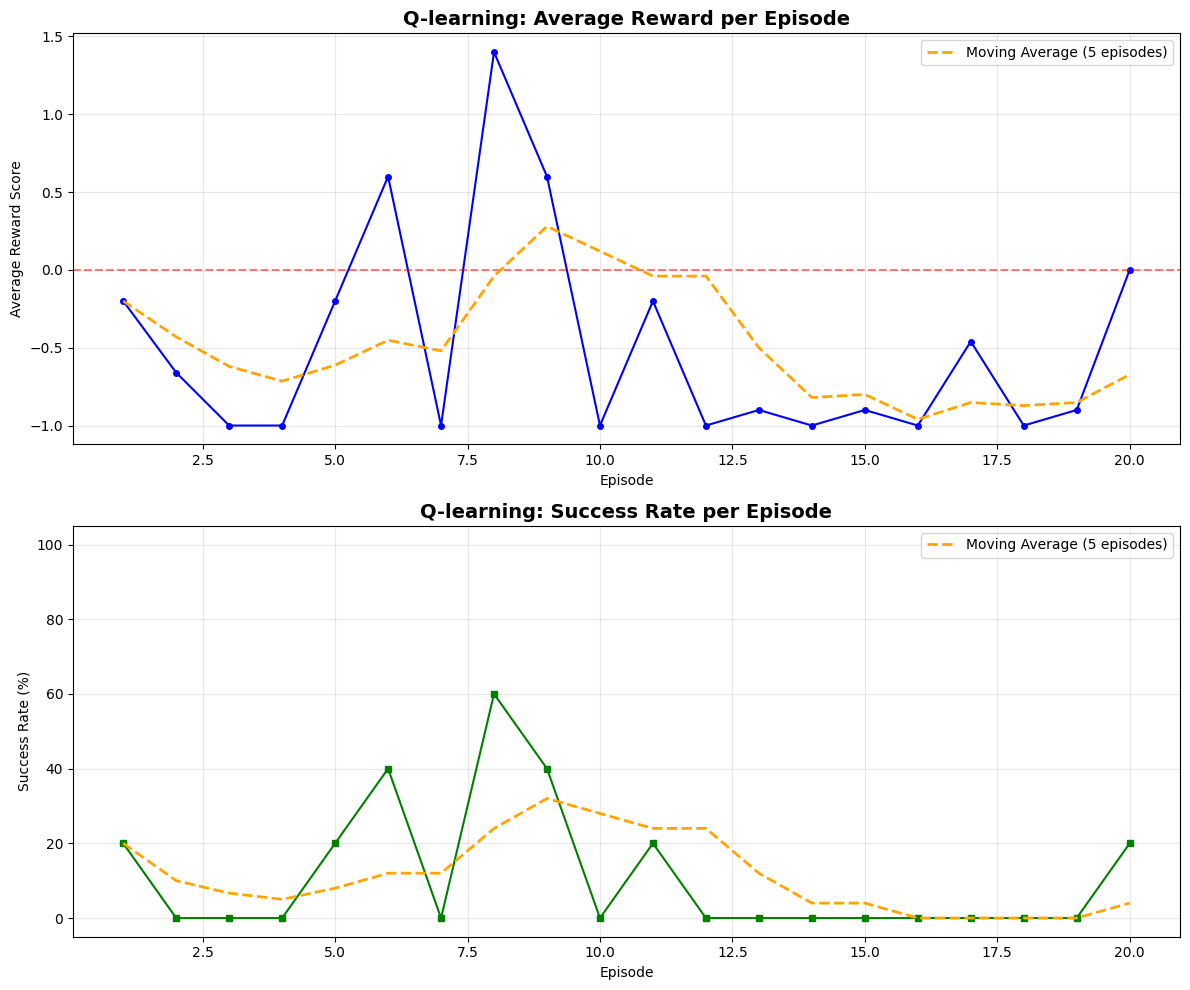


시각화 완료. 그래프는 에피소드가 진행됨에 따라 Q-learning 에이전트의 성능 변화를 보여줍니다.
보상 곡선이 우상향하고 성공률이 증가한다면, 에이전트가 성공적으로 학습하고 있다는 의미입니다.


In [17]:
# 8. Q-learning 학습 곡선 시각화

print("Q-learning 학습 곡선 시각화 중...")

if 'episode_rewards' in globals() and len(episode_rewards) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # 보상 곡선
    axes[0].plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o', linestyle='-', color='b', markersize=4)
    axes[0].set_title('Q-learning: Average Reward per Episode', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Average Reward Score')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # 이동 평균 추가 (최근 5 에피소드)
    if len(episode_rewards) >= 5:
        moving_avg = [np.mean(episode_rewards[max(0, i-4):i+1]) for i in range(len(episode_rewards))]
        axes[0].plot(range(1, len(moving_avg) + 1), moving_avg, color='orange', linestyle='--', linewidth=2, label='Moving Average (5 episodes)')
        axes[0].legend()
    
    # 성공률 곡선
    if 'episode_success_rates' in globals() and len(episode_success_rates) > 0:
        axes[1].plot(range(1, len(episode_success_rates) + 1), [r * 100 for r in episode_success_rates], 
                    marker='s', linestyle='-', color='g', markersize=4)
        axes[1].set_title('Q-learning: Success Rate per Episode', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Success Rate (%)')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(-5, 105)
        
        # 이동 평균 추가
        if len(episode_success_rates) >= 5:
            moving_avg_sr = [np.mean(episode_success_rates[max(0, i-4):i+1]) * 100 for i in range(len(episode_success_rates))]
            axes[1].plot(range(1, len(moving_avg_sr) + 1), moving_avg_sr, color='orange', linestyle='--', linewidth=2, label='Moving Average (5 episodes)')
            axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n시각화 완료. 그래프는 에피소드가 진행됨에 따라 Q-learning 에이전트의 성능 변화를 보여줍니다.")
    print("보상 곡선이 우상향하고 성공률이 증가한다면, 에이전트가 성공적으로 학습하고 있다는 의미입니다.")
else:
    print("경고: episode_rewards가 정의되지 않았습니다. 먼저 Cell 6을 실행하세요.")


In [18]:
# 8. 최종 성능 평가 (Testing)

print("========== 최종 프롬프트 성능 평가 시작 ==========")

# --- 테스트 루프 실행 ---
test_logs = []
test_rewards = []

# 테스트에서는 Q-learning으로 학습된 최종 프롬프트를 사용합니다.
if 'current_state' in globals() and 'base_prompt' in globals():
    # Q-learning으로 학습된 최종 상태에서 프롬프트 생성
    final_trained_prompt = build_prompt_from_state(current_state, base_prompt)
    print(f"Q-learning으로 학습된 최종 프롬프트 사용 (상태: {current_state.to_tuple()})")
elif 'log_df' in globals() and len(log_df) > 0:
    # 대체: log_df에서 마지막 프롬프트 사용
    final_trained_prompt = log_df['prompt_at_execution'].iloc[-1] if len(log_df) > 0 else SystemPrompt
    print("경고: log_df에서 프롬프트를 가져왔습니다.")
else:
    # 최후: 초기 프롬프트 사용
    final_trained_prompt = SystemPrompt
    print("경고: 초기 SystemPrompt를 사용합니다.")

test_inputs = []
for index, row in test_df.iterrows():
    test_inputs.append({
        "system_prompt": final_trained_prompt,
        "user_query": row['question'],
        "evidence": str(row['evidence']),
        "sql": str(row['SQL'])
    })

# 테스트셋 전체를 순차적으로 실행합니다.
# batch() 메서드 대신 invoke()를 사용합니다.
test_results = []
for test_input in test_inputs:
    try:
        result = eval_app.invoke(test_input)
        test_results.append(result)
    except Exception as e:
        print(f"테스트 입력 처리 중 오류: {e}")
        test_results.append({"evaluation_result": {"reward_score": -1.0, "correctness": "ERROR", "feedback": str(e)}, "llm_result": "ERROR"})

# --- 결과 분석 및 출력 ---
for idx, result in enumerate(test_results):
    reward = result.get('evaluation_result', {}).get('reward_score', -1.0)
    test_rewards.append(reward)
    
    test_logs.append({
        "index": test_df.index[idx],
        "question": test_inputs[idx]['user_query'],
        "used_prompt": final_trained_prompt,
        "generated_sql": result.get('llm_result', 'N/A'),
        "reward": reward,
        "correctness": result.get('evaluation_result', {}).get('correctness', 'N/A'),
    })

test_log_df = pd.DataFrame(test_logs)
test_log_df.to_csv("test_log_batch.csv", index=False, encoding='utf-8-sig')

avg_reward = np.mean(test_rewards)
success_rate = (np.array(test_rewards) >= 1.0).mean()

print("\n\n========== 최종 프롬프트 성능 평가 종료 ==========")
print(f"테스트 데이터셋 크기: {len(test_df)}개")
print(f"평균 보상 점수: {avg_reward:.3f}")
print(f"성공률 (보상 >= 1.0): {success_rate:.2%}")
print("\n테스트 상세 결과가 'test_log_batch.csv' 파일로 저장되었습니다.")

print("\n\n" + "="*25)
print("     최종 학습된 시스템 프롬프트")
print("="*25)
print(final_trained_prompt)


========== 최종 프롬프트 성능 평가 시작 ==========
Q-learning으로 학습된 최종 프롬프트 사용 (상태: (True, 1, False, 0, True, np.float64(0.2), np.float64(0.0)))


========== 최종 프롬프트 성능 평가 종료 ==========
테스트 데이터셋 크기: 47개
평균 보상 점수: -0.957
성공률 (보상 >= 1.0): 0.00%

테스트 상세 결과가 'test_log_batch.csv' 파일로 저장되었습니다.


     최종 학습된 시스템 프롬프트
당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다.



다음은 데이터베이스 스키마 정보입니다:

Schema for frpm:
(0, 'CDSCode', 'TEXT', 1, None, 1)
(1, 'Academic Year', 'TEXT', 0, None, 0)
(2, 'County Code', 'TEXT', 0, None, 0)
(3, 'District Code', 'INTEGER', 0, None, 0)
(4, 'School Code', 'TEXT', 0, None, 0)
(5, 'County Name', 'TEXT', 0, None, 0)
(6, 'District Name', 'TEXT', 0, None, 0)
(7, 'School Name', 'TEXT', 0, None, 0)
(8, 'District Type', 'TEXT', 0, None, 0)
(9, 'School Type', 'TEXT', 0, None, 0)
(10, 'Educational Option Type', 'TEXT', 0, None, 0)
(11, 'NSLP Provision Status', 'TEXT', 0, None, 0)
(12, 'Charter School (Y/N)', 'INTEGER', 0, None, 0)
(13, 'C

In [19]:
# 8. 최종 성능 평가 (Testing)

print("========== 최종 프롬프트 성능 평가 시작 ==========")

# --- 테스트를 위한 간소화된 그래프 정의 ---
# 테스트 단계에서는 프롬프트를 업데이트하지 않으므로, 'update_prompt' 노드가 없는
# 간단한 'generate -> evaluate' 그래프를 사용합니다.
test_workflow = StateGraph(SimpleGraphState)
test_workflow.add_node("generate_sql", generate_sql)
test_workflow.add_node("evaluate_sql", evaluate_sql)
test_workflow.set_entry_point("generate_sql")
test_workflow.add_edge("generate_sql", "evaluate_sql")
test_workflow.add_edge("evaluate_sql", END)
test_app = test_workflow.compile()

# --- 테스트 루프 실행 ---
test_logs = []
test_rewards = []

# final_trained_prompt 설정 (Q-learning 최종 프롬프트 사용)
if 'current_state' in globals() and 'base_prompt' in globals():
    final_trained_prompt = build_prompt_from_state(current_state, base_prompt)
    print(f"Q-learning으로 학습된 최종 프롬프트 사용 (상태: {current_state.to_tuple()})")
elif 'log_df' in globals() and len(log_df) > 0:
    final_trained_prompt = log_df['prompt_at_execution'].iloc[-1] if len(log_df) > 0 else SystemPrompt
    print("경고: log_df에서 프롬프트를 가져왔습니다.")
else:
    final_trained_prompt = SystemPrompt
    print("경고: 초기 SystemPrompt를 사용합니다.")

# tqdm 대신 일반 반복문 사용
print(f"테스트 진행 중... (총 {len(test_df)}개)")
for idx, (index, row) in enumerate(test_df.iterrows(), 1):
    if idx % 10 == 0:
        print(f"  {idx}/{len(test_df)} 처리 중...")
    # SystemPrompt = """당신은 사용자의 질문(user query)을 SQL 쿼리로 변환하는 전문가입니다. 주어진 질문의 의도를 정확히 파악하여, 올바른 결과를 반환하는 SQL 쿼리를 작성해야 합니다."""

    # 테스트에서는 'Sys'를 고정하여 사용합니다.
    initial_state = {
        "system_prompt": final_trained_prompt,
        "user_query": row['question'],
        "evidence": str(row['evidence']),
        "sql": str(row['SQL']),
        "retry_count": 0, # 테스트에서는 재시도 없음
    }
    
    try:
        final_state = test_app.invoke(initial_state)
        
        reward = final_state.get('evaluation_result', {}).get('reward_score', -1.0)
        test_rewards.append(reward)
        
        test_logs.append({
            "index": index,
            "question": row['question'],
            "used_prompt": final_trained_prompt,
            "generated_sql": final_state.get('llm_result', 'N/A'),
            "reward": reward,
            "correctness": final_state.get('evaluation_result', {}).get('correctness', 'N/A'),
        })

    except Exception as e:
        print(f"!!!!! 테스트 데이터 {index}에서 오류 발생: {e} !!!!!")
        test_rewards.append(-1.0)
        test_logs.append({
            "index": index, "question": row['question'], "used_prompt": final_trained_prompt,
            "generated_sql": "ERROR", "reward": -1.0, "correctness": "ERROR",
        })
        continue

# --- 결과 분석 및 출력 ---
test_log_df = pd.DataFrame(test_logs)
test_log_df.to_csv("test_log.csv", index=False, encoding='utf-8-sig')

avg_reward = np.mean(test_rewards)
success_rate = (np.array(test_rewards) >= 1.0).mean()

print("\n\n========== 최종 프롬프트 성능 평가 종료 ==========")
print(f"테스트 데이터셋 크기: {len(test_df)}개")
print(f"평균 보상 점수: {avg_reward:.3f}")
print(f"성공률 (보상 >= 1.0): {success_rate:.2%}")
print("\n테스트 상세 결과가 'test_log.csv' 파일로 저장되었습니다.")

print("\n\n" + "="*25)
print("     최종 학습된 시스템 프롬프트")
print("="*25)


========== 최종 프롬프트 성능 평가 시작 ==========
Q-learning으로 학습된 최종 프롬프트 사용 (상태: (True, 1, False, 0, True, np.float64(0.2), np.float64(0.0)))
테스트 진행 중... (총 47개)
  10/47 처리 중...
  20/47 처리 중...
  30/47 처리 중...
  40/47 처리 중...


========== 최종 프롬프트 성능 평가 종료 ==========
테스트 데이터셋 크기: 47개
평균 보상 점수: -0.957
성공률 (보상 >= 1.0): 0.00%

테스트 상세 결과가 'test_log.csv' 파일로 저장되었습니다.


     최종 학습된 시스템 프롬프트


In [20]:
# 성공률10% 

In [21]:
# 일반 Prompt
# 14.89#

In [22]:
# 배치사이즈
#8.51%


In [23]:
#2.03

In [24]:
#4.26%